<a href="https://colab.research.google.com/github/FAID-Nacera/Mini--projet--AI/blob/main/Mini_projet__FAID_NACERA__py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ================================
# INSTALLATION LIBRAIRIES
# ================================
!pip install shap lightgbm xgboost imbalanced-learn scikit-learn

In [2]:
# ================================
# 0. IMPORTATIONS
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
shap.initjs()
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, average_precision_score, silhouette_score
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, ADASYN
sns.set(style="whitegrid")
print("Bibliothèques chargées avec succès")

Bibliothèques chargées avec succès


Saving predictive_maintenance_dataset.csv to predictive_maintenance_dataset.csv
=== Dataset Loaded ===
Shape: (1800, 10)

5 premières lignes:
            timestamp machine_id  vibration  acoustic  temperature  current  \
0 2024-07-01 08:00:00        M01      0.822     0.645        66.85    13.04   
1 2024-07-01 08:00:00        M03      0.843     0.519        60.66    12.07   
2 2024-07-01 08:00:00        M02      0.726     0.617        63.28    12.33   
3 2024-07-01 08:01:00        M01      1.398     0.834        76.20    15.08   
4 2024-07-01 08:01:00        M03      0.785     0.566        63.56    11.84   

   IMF_1  IMF_2  IMF_3  label  
0  0.196  0.033  0.000      0  
1  0.197  0.014  0.000      0  
2  0.200  0.055  0.000      0  
3  0.345  0.132  0.001      1  
4  0.231  0.063  0.001      0  

=== Statistiques descriptives des capteurs ===
         vibration     acoustic  temperature     current        IMF_1  \
count  1800.000000  1800.000000  1800.000000  1800.00000  1800.000000 

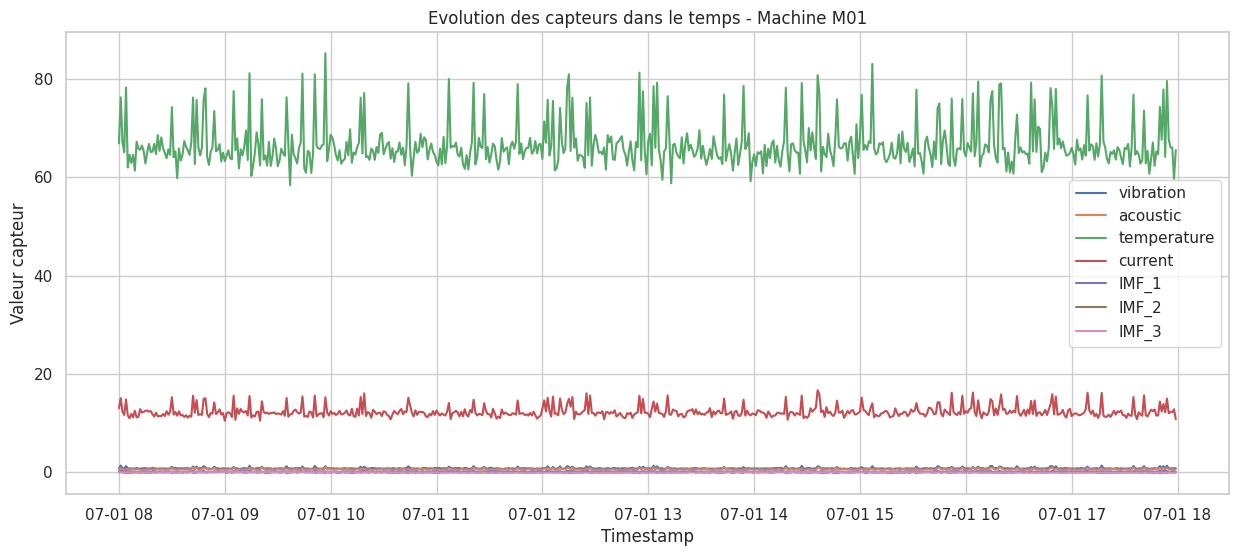

In [3]:
# ================================
# 1. IMPORTATION DU DATASET
# ================================
# Importation de "predictive_maintenance_dataset.csv" depuis Google Colab
from google.colab import files
files.upload()

# Chargement et prétraitement initial
df = pd.read_csv("predictive_maintenance_dataset.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values("timestamp").reset_index(drop=True)

# Définition des colonnes
target = "label"
sensor_cols = [c for c in df.select_dtypes(include=np.number).columns if c != target]

# Résumé du dataset
print("=== Dataset Loaded ===")
print(f"Shape: {df.shape}")
print("\n5 premières lignes:")
print(df.head())
print("\n=== Statistiques descriptives des capteurs ===")
print(df[sensor_cols].describe())
print("\n=== Distribution de la cible ===")
print(df[target].value_counts(normalize=True))

# Visualisation pour une machine
machine_id = 'M01'
if 'machine_id' in df.columns:
    df_machine = df[df['machine_id'] == machine_id]
    plt.figure(figsize=(15, 6))
    for col in sensor_cols:
        plt.plot(df_machine['timestamp'], df_machine[col], label=col)
    plt.title(f"Evolution des capteurs dans le temps - Machine {machine_id}")
    plt.xlabel("Timestamp")
    plt.ylabel("Valeur capteur")
    plt.legend()
    plt.show()
else:
    print("Colonne 'machine_id' non trouvée ; visualisation ignorée.")

In [4]:
# ================================
# 2. INGÉNIERIE DES CARACTÉRISTIQUES TEMPORELLES
# ================================
window = 5
for col in sensor_cols:
    df[f"{col}_mean"] = df[col].rolling(window).mean()
    df[f"{col}_std"] = df[col].rolling(window).std()
    df[f"{col}_max"] = df[col].rolling(window).max()
    df[f"{col}_min"] = df[col].rolling(window).min()
    df[f"{col}_lag1"] = df[col].shift(1)
    df[f"{col}_ratio"] = df[col] / (df[f"{col}_mean"] + 1e-6)

df.dropna(inplace=True)

if 'machine_id' in df.columns:
    df = pd.get_dummies(df, columns=['machine_id'], drop_first=True)

features = [c for c in df.columns if c not in [target, "timestamp"]]
X = df[features]
y = df[target]

print("\n=== Ingénierie des caractéristiques terminée ===")
print("Forme après ingénierie :", X.shape)
print("Exemple de caractéristiques :\n", X.head())


=== Ingénierie des caractéristiques terminée ===
Forme après ingénierie : (1796, 51)
Exemple de caractéristiques :
    vibration  acoustic  temperature  current  IMF_1  IMF_2  IMF_3  \
4      0.785     0.566        63.56    11.84  0.231  0.063  0.001   
5      0.815     0.589        63.28    11.65  0.092  0.097  0.001   
6      0.856     0.590        67.03    12.30  0.187  0.017  0.002   
7      1.047     0.825        77.67    14.51  0.308  0.121  0.002   
8      0.865     0.539        64.82    11.79  0.166 -0.101  0.002   

   vibration_mean  vibration_std  vibration_max  ...  IMF_2_lag1  IMF_2_ratio  \
4          0.9148       0.273744          1.398  ...       0.132     1.060588   
5          0.9134       0.274354          1.398  ...       0.063     1.343472   
6          0.9160       0.273581          1.398  ...       0.097     0.233513   
7          0.9802       0.254872          1.398  ...       0.017     1.406960   
8          0.8736       0.102146          1.047  ...       0.12

In [5]:
# ================================
# 3. SPLIT TEMPOREL (ANTI-FUITE)
# ================================
df_split = df.copy()

split_date = df_split['timestamp'].quantile(0.8)

train_indices = df_split['timestamp'] <= split_date
test_indices  = df_split['timestamp'] > split_date

X_train_full = X.loc[train_indices]
X_test_full  = X.loc[test_indices]
y_train = y.loc[train_indices]
y_test  = y.loc[test_indices]

print("\n=== Split temporel terminé ===")
print(f"X_train_full: {X_train_full.shape}, X_test_full: {X_test_full.shape}")
print("Distribution de y_train:\n", y_train.value_counts())
print("Distribution de y_test:\n", y_test.value_counts())


=== Split temporel terminé ===
X_train_full: (1439, 51), X_test_full: (357, 51)
Distribution de y_train:
 label
0    1288
1     151
Name: count, dtype: int64
Distribution de y_test:
 label
0    307
1     50
Name: count, dtype: int64


In [6]:
# ================================
# 4. NORMALISATION
# ================================
scaler = StandardScaler()

# Fit UNIQUEMENT sur le train
X_train_scaled = scaler.fit_transform(X_train_full)

# Transform sur le test avec le même scaler
X_test_scaled = scaler.transform(X_test_full)

# Conversion en DataFrame pour garder les noms de colonnes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_full.columns, index=X_train_full.index)
X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=X_test_full.columns,  index=X_test_full.index)

print("\n=== Normalisation terminée ===")
print("Forme X_train_scaled:", X_train_scaled_df.shape)
print("Forme X_test_scaled :", X_test_scaled_df.shape)
print("\nAperçu X_train_scaled :\n", X_train_scaled_df.head())

# Sauvegarde du scaler
joblib.dump(scaler, "scaler_features.joblib")
print("Scaler sauvegardé : scaler_features.joblib")


=== Normalisation terminée ===
Forme X_train_scaled: (1439, 51)
Forme X_test_scaled : (357, 51)

Aperçu X_train_scaled :
    vibration  acoustic  temperature   current     IMF_1     IMF_2     IMF_3  \
4  -0.415036 -0.619388    -0.622369 -0.438464  1.135819  0.863228 -0.278659   
5  -0.186148 -0.400536    -0.686258 -0.615302 -1.386891  1.329416 -0.278659   
6   0.126665 -0.391021     0.169402 -0.010329  0.337264  0.232503 -0.248824   
7   1.583916  1.845078     2.597195  2.046580  2.533292  1.658489 -0.248824   
8   0.195331 -0.876301    -0.334867 -0.485000 -0.043865 -1.385443 -0.248824   

   vibration_mean  vibration_std  vibration_max  ...  IMF_2_lag1  IMF_2_ratio  \
4        1.311200       2.160685       2.188246  ...    1.807939     0.004808   
5        1.286725       2.168656       2.188246  ...    0.862382     0.004900   
6        1.332179       2.158557       2.188246  ...    1.328309     0.004538   
7        2.454522       1.914280       2.188246  ...    0.232011     0.004921 


=== PCA terminé  ===
Dimension avant PCA: 51
Dimension après PCA: 24
Variance expliquée totale: 0.95683780878728


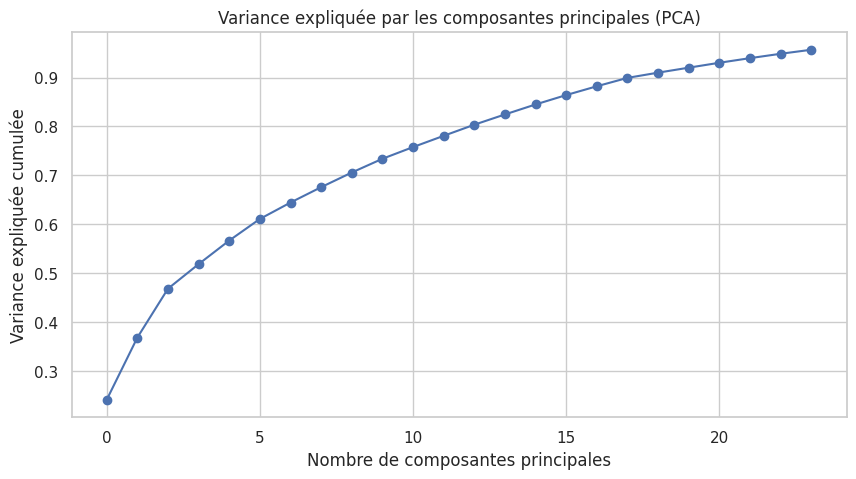

PCA sauvegardé : pca_model.joblib
Forme X_train_pca: (1439, 24)
Forme X_test_pca : (357, 24)


In [7]:
# ================================
# 5. PCA (RÉDUCTION DE DIMENSIONNALITÉ)
# ================================

pca = PCA(n_components=0.95, random_state=42)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("\n=== PCA terminé  ===")
print("Dimension avant PCA:", X_train_scaled.shape[1])
print("Dimension après PCA:", X_train_pca.shape[1])
print("Variance expliquée totale:", np.sum(pca.explained_variance_ratio_))

# ================================
# Visualisation variance expliquée cumulée
# ================================

explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_var), marker='o')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée par les composantes principales (PCA)')
plt.grid(True)
plt.show()

# ================================
# Sauvegarde du PCA
# ================================

joblib.dump(pca, "pca_model.joblib")
print("PCA sauvegardé : pca_model.joblib")

# ================================
# Vérification formes finales
# ================================

print("Forme X_train_pca:", X_train_pca.shape)
print("Forme X_test_pca :", X_test_pca.shape)


=== Clustering terminé ===
Meilleur k pour KMeans : 3 (silhouette = 0.260)
KMeans sauvegardé : kmeans_model.joblib
Distribution KMeans (train):
1    822
0    466
2    151
Name: count, dtype: int64


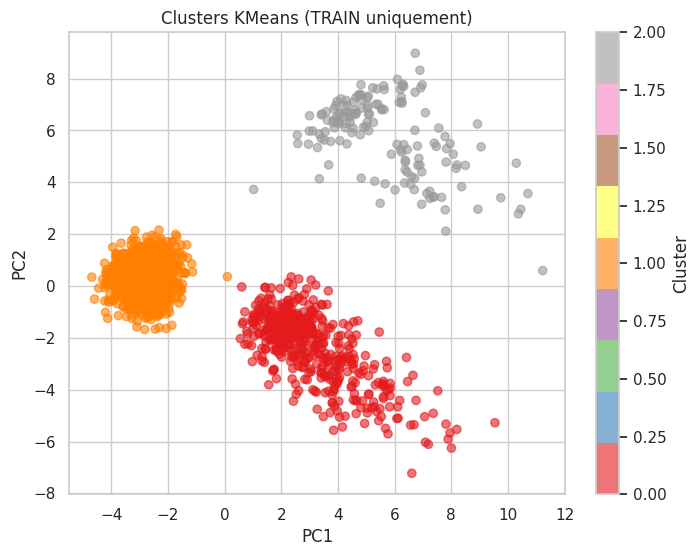


Taux de panne par cluster (TRAIN):
label      0    1
cluster          
0        1.0  0.0
1        1.0  0.0
2        0.0  1.0


In [8]:
# ================================
# 6. CLUSTERING NON SUPERVISÉ
# ================================

k_options = [2, 3, 4, 5]
best_k = 2
best_score = -1

for k in k_options:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters_temp = kmeans_temp.fit_predict(X_train_pca)
    score = silhouette_score(X_train_pca, clusters_temp)

    if score > best_score:
        best_score = score
        best_k = k

print(f"\n=== Clustering terminé ===")
print(f"Meilleur k pour KMeans : {best_k} (silhouette = {best_score:.3f})")

# Entraînement final sur TRAIN
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters_train = kmeans.fit_predict(X_train_pca)

# Application sur TEST
clusters_test = kmeans.predict(X_test_pca)

# Sauvegarde du modèle
joblib.dump(kmeans, "kmeans_model.joblib")
print("KMeans sauvegardé : kmeans_model.joblib")

# Enrichissement des features
X_train_enriched = pd.DataFrame(X_train_pca, columns=[f"PC{i+1}" for i in range(X_train_pca.shape[1])])
X_test_enriched  = pd.DataFrame(X_test_pca,  columns=[f"PC{i+1}" for i in range(X_test_pca.shape[1])])

X_train_enriched["cluster_kmeans"] = clusters_train.astype(int)
X_test_enriched["cluster_kmeans"]  = clusters_test.astype(int)

print("Distribution KMeans (train):")
print(pd.Series(clusters_train).value_counts())

plt.figure(figsize=(8, 6))
plt.scatter(X_train_enriched["PC1"], X_train_enriched["PC2"],
            c=clusters_train, cmap="Set1", alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters KMeans (TRAIN uniquement)")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()

print("\nTaux de panne par cluster (TRAIN):")
df_clusters = pd.DataFrame({
    "cluster": clusters_train,
    "label": y_train.values
})

print(pd.crosstab(df_clusters["cluster"], df_clusters["label"], normalize="index"))

In [9]:
# ================================
# 7. APPLICATION DU SPLIT TEMPOREL À X_ENRICHED
# ================================
X_train = X_train_enriched
X_test  = X_test_enriched

print("\n=== Données ML prêtes ===")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")



=== Données ML prêtes ===
X_train: (1439, 25), X_test: (357, 25)
y_train: (1439,), y_test: (357,)


In [10]:
# ================================
# 8. SMOTE (ÉQUILIBRAGE)
# ================================
X_train.columns = X_train.columns.astype(str)
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)
baseline = LogisticRegression(max_iter=1000, random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
f1_smote = cross_val_score(baseline, X_train_smote, y_train_smote, cv=3, scoring='f1_macro').mean()
print(f"\n=== SMOTE/ADASYN ===")
print(f"F1 SMOTE = {f1_smote:.4f}")

try:
    X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
    f1_adasyn = cross_val_score(baseline, X_train_adasyn, y_train_adasyn, cv=3, scoring='f1_macro').mean()
    print(f"F1 ADASYN = {f1_adasyn:.4f}")
    if f1_smote >= f1_adasyn:
        X_train_res, y_train_res = X_train_smote, y_train_smote
        print("✅ SMOTE choisi (meilleur ou égal F1).")
    else:
        X_train_res, y_train_res = X_train_adasyn, y_train_adasyn
        print("✅ ADASYN choisi (meilleur F1).")
except RuntimeError as e:
    print("⚠️ ADASYN impossible sur ce dataset :", e)
    print("✅ SMOTE utilisé par défaut.")
    X_train_res, y_train_res = X_train_smote, y_train_smote

print("Après équilibrage :")
print("X_train_res:", X_train_res.shape)
print("Distribution y_train_res:\n", pd.Series(y_train_res).value_counts())



=== SMOTE/ADASYN ===
F1 SMOTE = 1.0000
F1 ADASYN = 1.0000
✅ SMOTE choisi (meilleur ou égal F1).
Après équilibrage :
X_train_res: (2576, 25)
Distribution y_train_res:
 label
0    1288
1    1288
Name: count, dtype: int64


In [11]:
# ================================
# 9. MODÈLE SUPERVISÉ (STACKING AVEC TUNING)
# ================================
xgb_model = XGBClassifier(eval_metric="mlogloss", random_state=42)
lgbm_model = LGBMClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
meta_model = XGBClassifier(eval_metric="mlogloss", random_state=42)

param_grid = {
    "xgb__n_estimators": [100, 200],
    "lgbm__n_estimators": [100, 200],
    "rf__n_estimators": [100, 200],
}

stack_model = StackingClassifier(
    estimators=[("xgb", xgb_model), ("lgbm", lgbm_model), ("rf", rf_model)],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

grid_search = GridSearchCV(estimator=stack_model, param_grid=param_grid, cv=3, scoring="f1_macro", n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)
stack_model = grid_search.best_estimator_

print("\n=== StackingClassifier Tuned and Fitted ===")
print("Meilleurs paramètres :", grid_search.best_params_)



=== StackingClassifier Tuned and Fitted ===
Meilleurs paramètres : {'lgbm__n_estimators': 100, 'rf__n_estimators': 100, 'xgb__n_estimators': 100}



=== PERFORMANCE STACKING ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       307
           1       1.00      1.00      1.00        50

    accuracy                           1.00       357
   macro avg       1.00      1.00      1.00       357
weighted avg       1.00      1.00      1.00       357


=== MATRICE DE CONFUSION ===
[[307   0]
 [  0  50]]


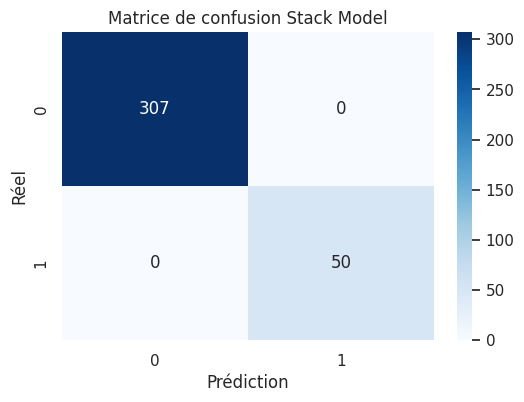

Précision entraînement : 1.000
Précision test : 1.000
Macro F1 de validation croisée : [1.        1.        1.        0.9908324 1.       ]
Moyenne : 0.9981664809804233
Macro F1 glissante moyen (fenêtre 10) : 1.000
Clustering non défini, ablation study ignorée.


In [12]:
# ================================
# 10. ÉVALUATION
# ================================

# Prédictions du modèle Stacking
y_pred_train = stack_model.predict(X_train)
y_pred = stack_model.predict(X_test)

print("\n=== PERFORMANCE STACKING ===")
print(classification_report(y_test, y_pred))

# Matrice de confusion
print("\n=== MATRICE DE CONFUSION ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion Stack Model")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.show()

# Précision entraînement / test
train_acc = np.mean(y_pred_train == y_train)
test_acc = np.mean(y_pred == y_test)
print(f"Précision entraînement : {train_acc:.3f}")
print(f"Précision test : {test_acc:.3f}")

# Validation croisée F1-macro
cv_f1 = cross_val_score(stack_model, X_train, y_train, cv=5, scoring='f1_macro')
print("Macro F1 de validation croisée :", cv_f1)
print("Moyenne :", cv_f1.mean())

# F1 glissant (rolling) sur test
window = 10
y_test_series = pd.Series(y_test).reset_index(drop=True)
y_pred_series = pd.Series(y_pred).reset_index(drop=True)

rolling_f1 = []
for i in range(len(y_test_series) - window + 1):
    f1_win = f1_score(y_test_series[i:i+window], y_pred_series[i:i+window], average='macro')
    rolling_f1.append(f1_win)

print(f"Macro F1 glissante moyen (fenêtre {window}) : {np.mean(rolling_f1):.3f}")

# Étude d'impact du clustering
try:
    y_pred_no_cluster = stack_model_no_cluster.predict(X_test_no_cluster)
    f1_no_cluster = f1_score(y_test_no_cluster, y_pred_no_cluster, average='macro')
    f1_with_cluster = f1_score(y_test, y_pred, average='macro')
    print(f"F1-macro sans clustering : {f1_no_cluster:.3f} (vs. avec clustering : {f1_with_cluster:.3f})")
except NameError:
    print("Clustering non défini, ablation study ignorée.")

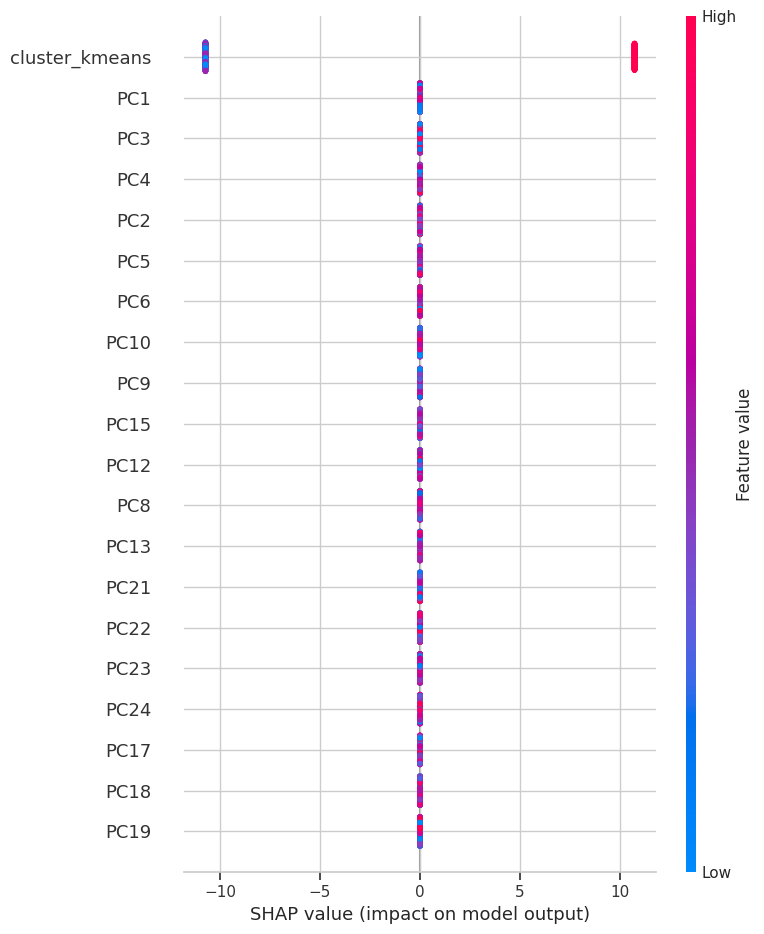

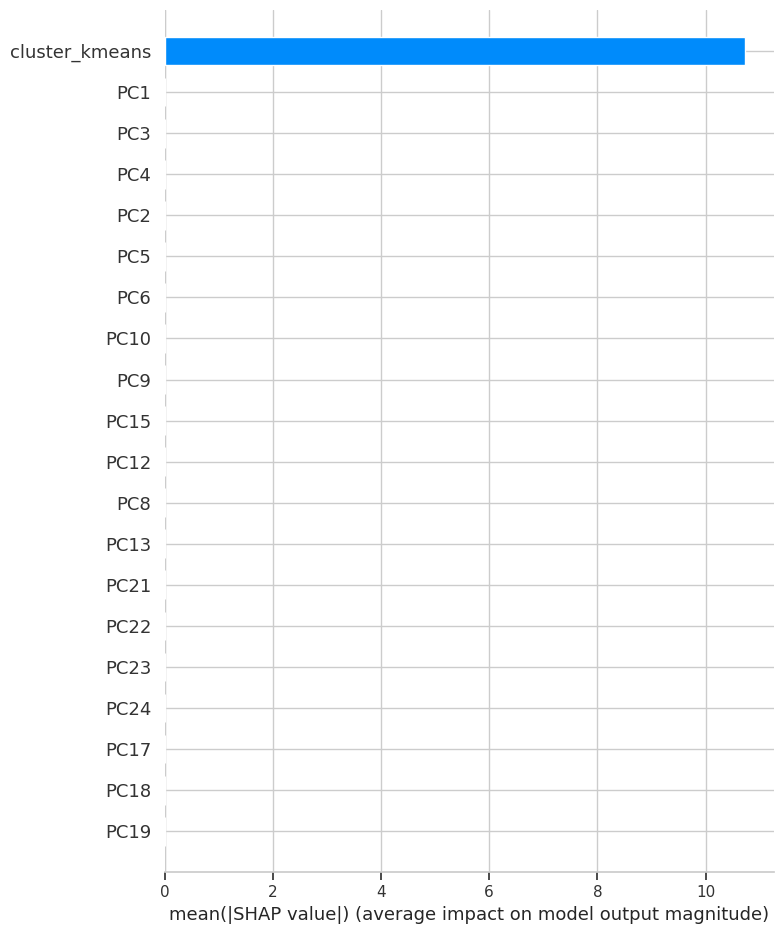

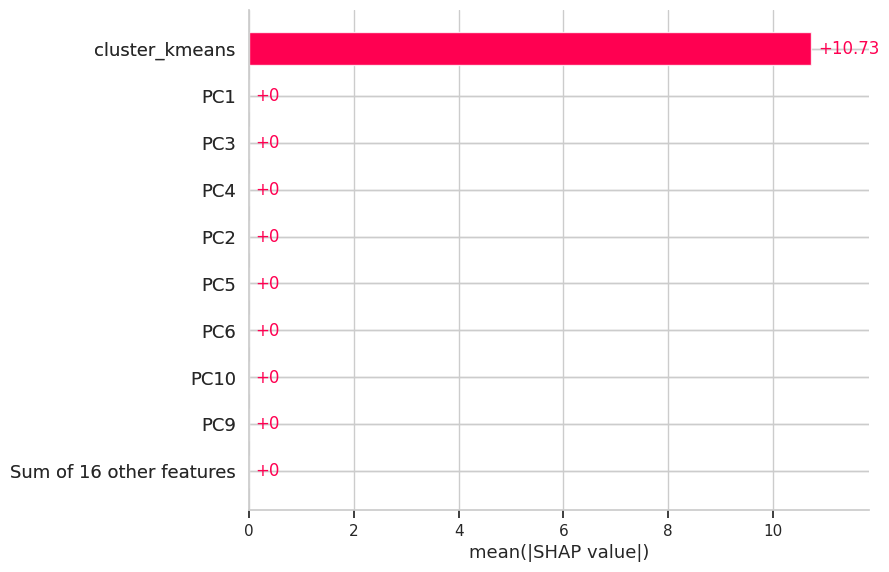

In [13]:
# ================================
# 11. SHAP EXPLAINABILITY
# ================================

# Modèle LightGBM interne
lgbm_model_fitted = stack_model.named_estimators_["lgbm"]

# Échantillon
X_shap = X_train_res.sample(500, random_state=42)

# Explainer
explainer = shap.TreeExplainer(lgbm_model_fitted)
shap_values = explainer(X_shap)

# Summary plots
shap.summary_plot(shap_values)
shap.summary_plot(shap_values, plot_type="bar")

# Feature importance interactive
shap.plots.bar(shap_values, max_display=10)


In [14]:
# ================================
# 12. SAUVEGARDE ET FIN
# ================================
joblib.dump(stack_model, "stacking_model.joblib")
print("\nModèle sauvegardé : stacking_model.joblib")
print("\n=== Pipeline terminé ===")


Modèle sauvegardé : stacking_model.joblib

=== Pipeline terminé ===
